# 0. Preparing the environment

## This will only load the required libraries, in R, the equivalent is to call `library("tidiverse")`

## We will also declare a function we'll use later

In [1]:
import ipywidgets as     widgets
import numpy      as     np
import pandas     as     pd
import seaborn    as     sns
from   matplotlib import pyplot as plt
from   pyDOE2     import ff2n
from   upsetplot  import UpSet,plot

In [2]:
def get_og_class(og_tuple):
    og_class = binary_dict[og_tuple]
    return og_class

# 1. Preparing the files

## Two files are required for the analysis:

- ### `Orthogroups.GeneCount.tsv` that, as the name implies, contains the number of genes per orthogroup per species
- ### `Orthogroups.GeneCount.tsv` that, as the name implies, contains the number of exclusive genes per species

### We will load the files into separate pandas dataframes.
### In addition, from the dataframe header we will extract a list of the species

In [5]:
assigned_df   = pd.read_csv("Orthogroups.GeneCount.tsv",sep="\t")
unassigned_df = pd.read_csv("Orthogroups_UnassignedGenes.tsv",sep="\t",dtype=str).fillna("")
org_list      = list(assigned_df.columns.values)[1:-1]

### Because the list of unassigned genes contains an "orthogroup" per gene per species, the resulting dataframe is excessively long, witht the following lines we can collapse the dataframe into a symmetrical matrix containing a single row per species indicating how many exclusive genes per species we have

In [6]:
missing_list = []
for org_name in org_list:
    org_index = str(org_list.index(org_name))
    missed_og_name = "MISSING_OG"+org_index
    sub_total = len(unassigned_df[unassigned_df[org_name]!= ""])
    missed_og_dict = {}
    missed_og_dict["Orthogroup"] = missed_og_name
    for sub_org in org_list:
        if (sub_org==org_name):
            sub_total_value = sub_total
        else:
            sub_total_value = 0
        missed_og_dict[sub_org] = sub_total_value
    missing_list.append(missed_og_dict)
missing_df = pd.DataFrame.from_records(missing_list)

### And then we can put the two dataframes together

In [7]:
ortho_df = pd.concat([assigned_df, missing_df], sort=False)

In [ ]:
o

# 2. Selecting the species

## The following code is just to make things interactive, here you can select as many species as you want for your figure

> ## Note that if you modify the list of selected species, you need to run all cells from here onwards

In [8]:
checkboxes = [widgets.Checkbox(value=False, description=label,indent=False) for label in org_list]
output = widgets.VBox(children=checkboxes,)
display(output)

In [9]:
sel_org_list = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        sel_org_list = sel_org_list + [checkboxes[i].description]

### Based on the selected organisms, we'll build a binary matrix that includes all the possibilities for an orthogroup to be shared across the number of species

### As an example, a list of 3 organisms will produce 8 different orthogroup classes

|Species 1|Species 2|Species 3|Orthogroup class|
|:-------:|:-------:|:-------:|:--------------:|
|Present  |Present  |Present  |        0       |
|Present  |Present  |Absent   |        1       |
|Present  |Absent   |Present  |        2       |
|Present  |Absent   |Absent   |        3       |
|Absent   |Present  |Present  |        4       |
|Absent   |Present  |Absent   |        5       |
|Absent   |Absent   |Present  |        6       |
|Absent   |Absent   |Absent   |        7       |

### The number of orthogroup classes grows exponentially with respect to the number of organisms, this is also the number of bars in your figure, thus, it is important to keep the number sensible not to produce an overly large and massively unreadable figure, also, not to consume too much memory

In [10]:
num_sel_orgs  = len(sel_org_list)
binary_matrix = ff2n(num_sel_orgs)
binary_list   = binary_matrix.tolist()
binary_tuple  = [tuple(row) for row in binary_list]
class_list    = list(range(0,len(binary_tuple)))
binary_dict   = dict(zip(binary_tuple,class_list))

# 3. Data transformation

## We will produce two additional columns, one containing the number of orthogroups, and another containing the number of genes, that will make sense later

In [11]:
sub_cols  = ["Orthogroup"] + sel_org_list
sub_df    = ortho_df.copy()
sub_df    = sub_df[sub_cols]
sub_df["gene_total"] = sub_df.loc[:,sub_df.columns != "Orthogroup"].apply(np.sum, axis=1)
sub_df    = sub_df[sub_df["gene_total"]!=0]
for org_name in sel_org_list:
    sub_df[org_name] = sub_df[org_name].apply(lambda x: 1 if x > 0 else -1)
sub_df["og_total"] = sub_df.apply(lambda x: x["gene_total"] if "MISS" in x["Orthogroup"] else 1,axis=1)

## We then encode the orthogroup dataframe into a binary matrix so that we can decode the orthogroup classes based on their presence or absence across the selected species

In [12]:
sub_df["og_class"] = sub_df[sel_org_list].apply(lambda x: get_og_class(tuple(x.values.flatten().tolist())),axis=1)

## Then we calculate the total number of orthogroups and the total number of genes per class

In [13]:
tuple_list        = []
class_og_totals   = []
class_gene_totals = []
for value in binary_dict.values():
    presence_tuple = [k for k,v in binary_dict.items() if v == value][0]
    presence_list  = list(presence_tuple)
    index_list = []
    for dummy,(matrix_value,organism) in enumerate(zip(presence_list,sel_org_list)):
        if matrix_value == 1:
            index_list.append(True)
        else:
            index_list.append(False)
    class_og_total   = np.sum(sub_df[sub_df["og_class"]==value]["og_total"])
    class_gene_total = np.sum(sub_df[sub_df["og_class"]==value]["gene_total"])
    class_og_totals.append(class_og_total)
    class_gene_totals.append(class_gene_total)
    index_tuple = tuple(index_list)
    tuple_list.append(index_tuple)

## Based on the number of species and the number of classes we'll build two dataframes, one containing the total number of orthogroups per class and one containing the total number of genes per class

In [14]:
multi_index = pd.MultiIndex.from_tuples(tuple_list,names=sel_org_list)
upset_og_df   = pd.Series(class_og_totals,index=multi_index)
upset_gene_df = pd.Series(class_gene_totals,index=multi_index)

# 4. Plotting your results

## Once you have the last two dataframes, you can plot them with the following code, the options are self explanatory and you can save your figure to a file, the extension dictates the file format

### Code to plot the orthogroup totals

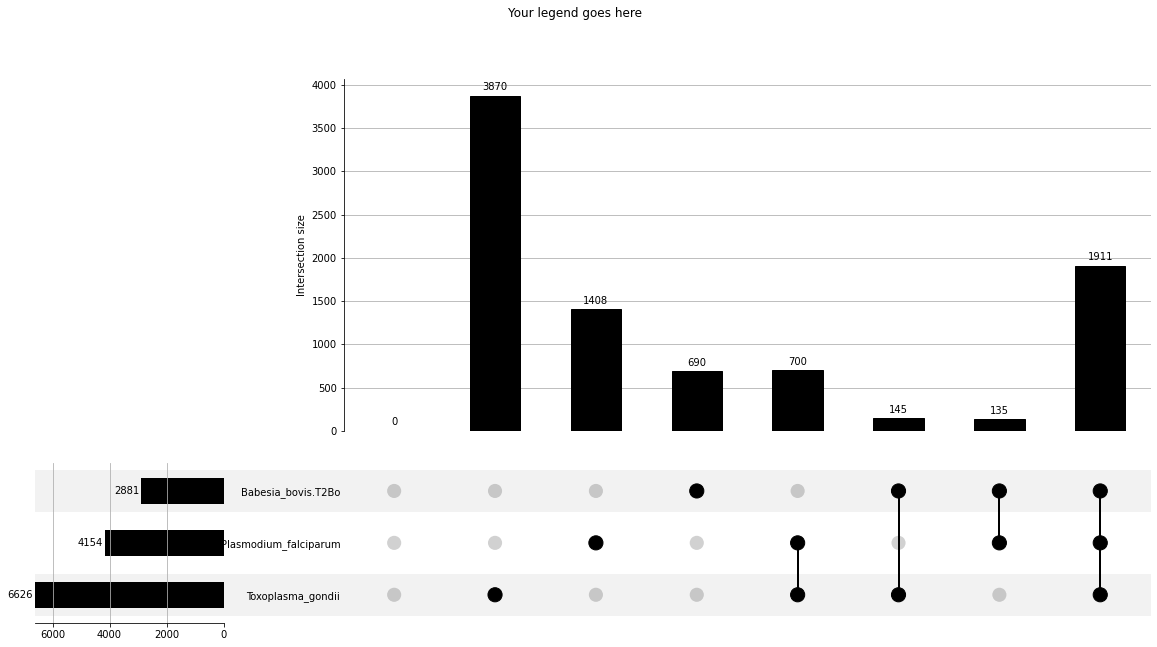

In [15]:
fig = plt.figure(figsize=(20,10))
upset = plot(upset_og_df, fig=fig, element_size=None,show_counts=True)
plt.suptitle("Your legend goes here")
plt.savefig("og_upset_plot.svg")
plt.show()

### Code to plot the gene totals

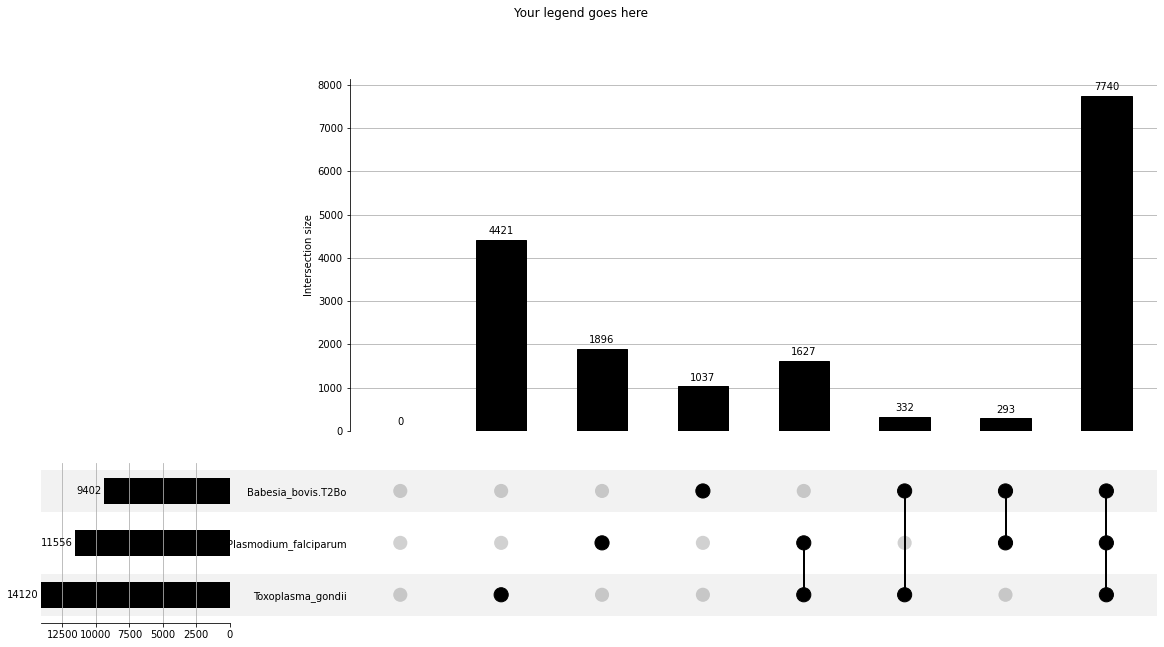

In [16]:
fig = plt.figure(figsize=(20,10))
upset = plot(upset_gene_df, fig=fig, element_size=None,show_counts=True)
plt.suptitle("Your legend goes here")
plt.savefig("gene_upset_plot.svg")
plt.show()

# 5. Notes

## As opposed to plotting the missing values across different channels in TMT tagging, plotting the results of orthogroups presents specific challenges:

- ### The number of genes per orthogroup might be different across species
- ### The identifiers of shared genes are not identical across species
- ### The number of genes per species might differ quite significantly

## Let's consider the following toy example:

|Orthogroup|Species 1|Species 2|Species 3|OG Class|
|:--------:|:-------:|:-------:|:-------:|:------:|
|OG0001    |  1000   |     1   |   10    |    0   |
|OG0002    |     1   |  1000   |   10    |    0   |
|OG0003    |    10   |     0   |   10    |    2   |
|OG0004    |     0   |    10   |   10    |    4   |

The resulting plot will display results that might be somewhat deceiving, 2 Orthogroups shared across the 3 species, 1 orthogroup shared across 2 species, and 1 orthogroup shared in 2 different species. But the gene counts tell a different story: while orthogroups 1 and 2 are conserved across all three species, they were massively expanded in species 1 and 2, thus, plotting the actual number of genes is helpful (to some extent).

There is a caveat to this approach though, because UpsetPlot assume a symetric distribution of the intersected data, the number of genes is inflated in the second plot, thus, the side bars should be removed from the plot, in addition, a pie chart on top of each category could also help to see what species present more genes in each category but so far that has not been implemented